# Regressione con regolarizzazione, funzioni kernel, cross validation, grid search

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

Importare i package necessari e configurare l'output di matplotlib

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Caso di studio: predizione consumo elettricità

Carichiamo i dati già visti nei laboratori precedenti: per ogni giorno degli anni dal 2015 al 2017 abbiamo la temperatura media in una città e il picco registrato di consumo di corrente elettrica

- con l'opzione `index_col` specifichiamo che la colonna `date` costituisce l'indice del DataFrame
- con `parse_dates` indichiamo che i suoi valori vanno interpretati come date

In [43]:
POWER_DATA_URL = "https://github.com/datascienceunibo/dialab2024/raw/main/Regressione_non_Lineare/power.csv"

import os.path
if not os.path.exists("power.csv"):
    from urllib.request import urlretrieve
    urlretrieve(POWER_DATA_URL, "power.csv")

In [44]:
power = pd.read_csv("power.csv", index_col="date", parse_dates=["date"])

In [45]:
power.head(8)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0
2015-01-06,2.122799,-6.7
2015-01-07,2.243265,-9.4
2015-01-08,2.240975,-8.9


Vogliamo costruire un modello che consenta la predizione del consumo di corrente sulla base della temperatura in un qualsiasi giorno dell'anno

Come nello scorso laboratorio, suddividiamo i dati in

- un _training set_ `*_train` con i dati relativi all'anno 2015
- un _test set_ `*_test` con i dati relativi agli anni 2016 e 2017

Per ciascuno estraiamo

- una matrice `X_*` $N\times 1$ con le osservazioni delle variabili indipendenti: in questo caso una sola, la temperatura
- un vettore `y_*` con gli $N$ corrispondenti valori della variabile dipendente: i consumi

In [46]:
is_train = power.index.year < 2016
X_train = power.loc[is_train, ["temp"]]
y_train = power.loc[is_train, "demand"]
X_test = power.loc[~is_train, ["temp"]]
y_test = power.loc[~is_train, "demand"]

## Valutazione dei modelli

Abbiamo visto tre diverse metriche per la valutazione dell'accuratezza dei modelli di regressione

- l'_errore quadratico medio_, usato nella discesa del gradiente ma più difficilmente interpretabile
- l'_errore relativo_, noto in letteratura come _mean absoulte percentage error_ (MAPE), che indica intuitivamente la percentuale di errore del modello
- il _coefficiente R²_, che esprime l'accuratezza con un indice tra 0 e 1

Riprendiamo la funzione `print_eval` definita nella scorsa esercitazione per calcolare e stampare le tre metriche su un set di dati e un modello indicati

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

Riprendiamo anche la funzione `plot_model_on_data` per visualizzare un grafico del modello addestrato sovrapposto ai dati

In [48]:
def plot_model_on_data(X, y, model=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_x_df = pd.DataFrame(line_x[:, None], columns=X.columns)
        line_y = model.predict(line_x_df)
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (°C)"); plt.ylabel("Consumi (GW)")

### Esercizio 1: Ripasso modelli

Addestrare sul training set creato sopra tre modelli diversi con le seguenti configurazioni, per ciascuno stampare le misure di valutazione sul test set e visualizzare il modello sovrapposto ad esso

- **(1a)** regressione lineare semplice
- **(1b)** regressione polinomiale di grado 2
- **(1c)** regressione polinomiale di grado 3 con standardizzazione delle variabili polinomiali generate

In [49]:
# sono eseguiti quì tutti gli import necessari da scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [50]:
# 1a
model_a = LinearRegression()
model_a.fit(X_train, y_train)
print_eval(X_test, y_test, model_a)

   Mean squared error: 0.097075
       Relative error: 15.39235%
R-squared coefficient: 0.095201


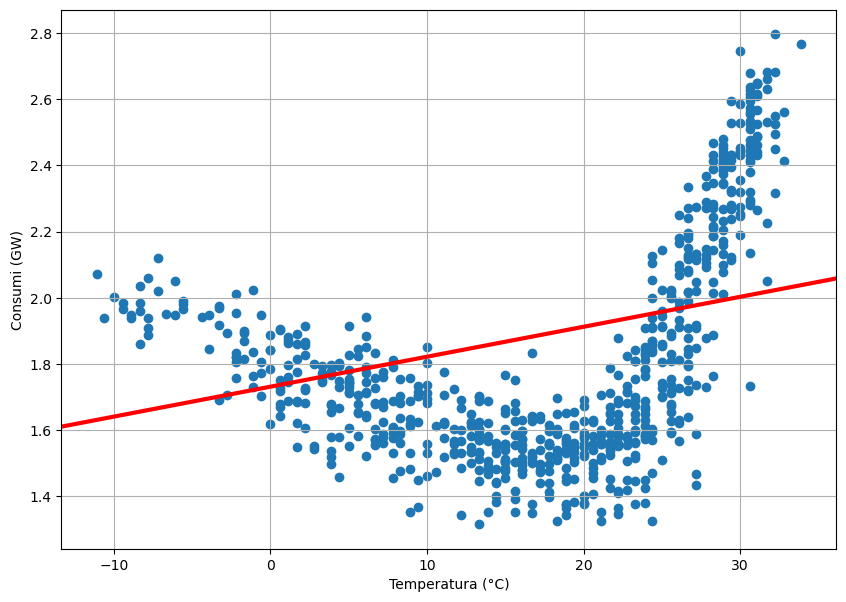

In [51]:
plot_model_on_data(X_test, y_test, model_a)

In [52]:
# 1b
model_b = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)
model_b.fit(X_train, y_train)
print_eval(X_test, y_test, model_b)

   Mean squared error: 0.037151
       Relative error: 8.89180%
R-squared coefficient: 0.65373


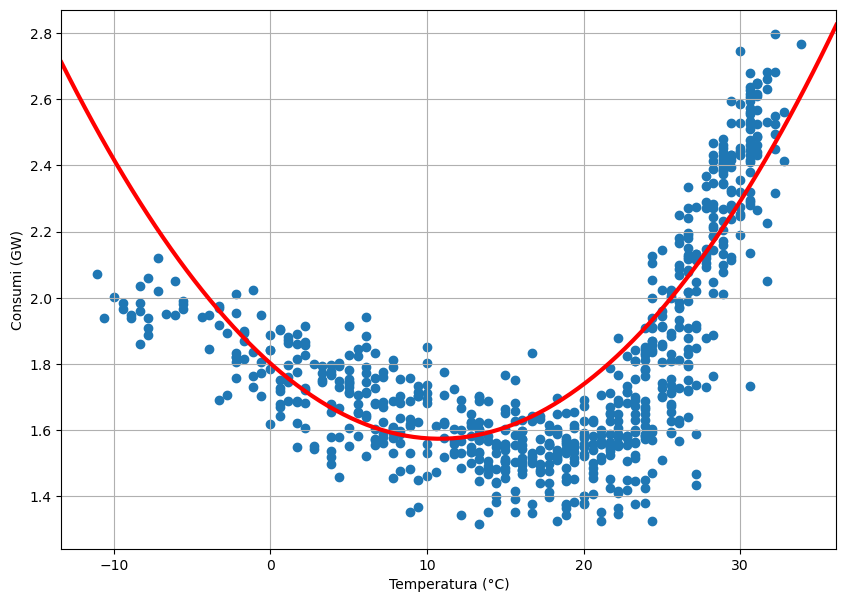

In [53]:
plot_model_on_data(X_test, y_test, model_b)

In [54]:
# 1c
model_c = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    StandardScaler(),
    LinearRegression()    
)
model_c.fit(X_train, y_train)
print_eval(X_test, y_test, model_c)

   Mean squared error: 0.025885
       Relative error: 7.18888%
R-squared coefficient: 0.75874


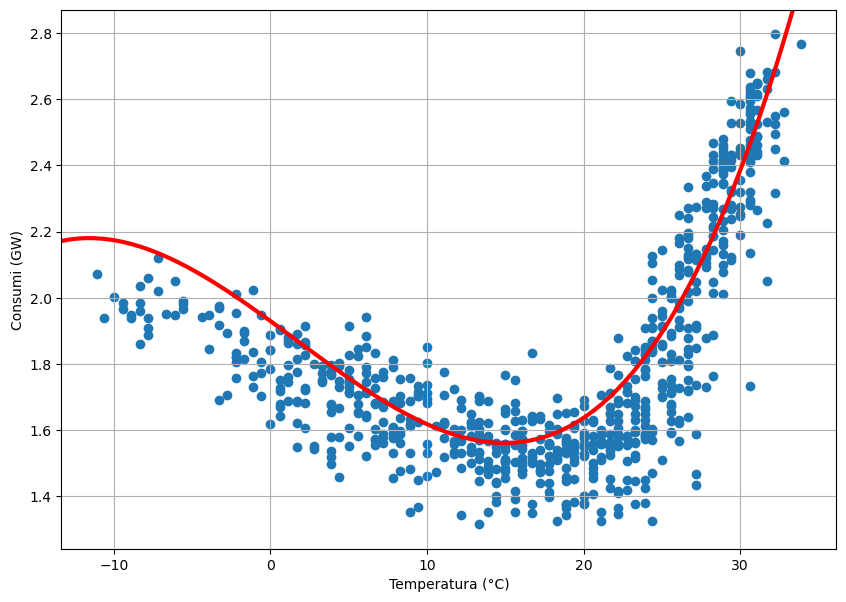

In [55]:
plot_model_on_data(X_test, y_test, model_c)

## Regolarizzazione e regressione ridge

Abbiamo visto come l'addestramento di un modello si compia minimizzando l'errore sui dati di addestramento, dato da

$$ E = \mathrm{media}\left(\left(\mathbf{X}\mathbf{\theta}-\mathbf{y}\right)^2\right) $$

Per l'esattezza, la formula su cui si basa `LinearRegression` è

$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 $$

Dove la _norma euclidea_ (o _norma 2_) $\left\Vert\mathbf{x}\right\Vert_2$ di un vettore $\mathbf{x}$ di $n$ elementi è

$$ \left\Vert\mathbf{x}\right\Vert_2 = \sqrt{\sum_{i=1}^n x_i^2} = \sqrt{x_1^2+\ldots+x_n^2} $$

Tuttavia, questo non garantisce l'accuratezza del modello in generale

Soprattutto se il modello ha molti parametri, è possibile che questi vengano "forzati" a funzionare bene sui dati d'addestramento, rendendo però il modello poco accurato in generale

Addestriamo ad esempio un modello polinomiale di grado 30 con standardizzazione

In [56]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=30, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=30, include_bias=False)),
                ('scale', StandardScaler()), ('linreg', LinearRegression())])

Valutiamone le misure di accuratezza sia sul training set che sul test set

In [57]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.020911
       Relative error: 6.23031%
R-squared coefficient: 0.80479


In [58]:
print_eval(X_test, y_test, prm)

   Mean squared error: 30.95
       Relative error: 14.77010%
R-squared coefficient: -287.47


La differenza tra le misure suggerisce che il modello sia stato addestrato "troppo bene" sul training set ma non sia abbastanza generale (_overfitting_)

A dimostrazione, si veda il grafico del modello sovrapposto ai dati del training set

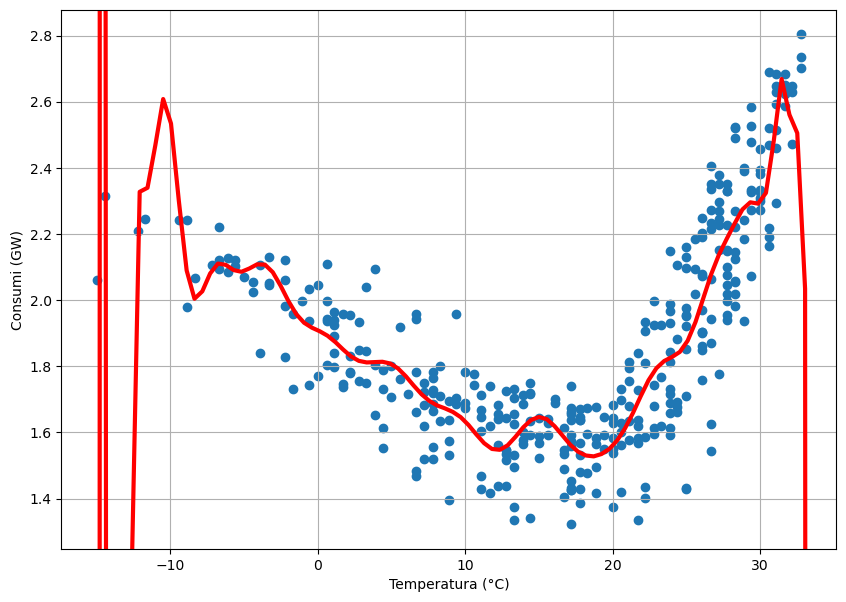

In [59]:
plot_model_on_data(X_train, y_train, prm)

Soprattutto nella parte a sinistra, si nota che il modello è stato ottimizzato per minimizzare l'errore anche in casi estremi del training set

Vediamo ora il modello sovrapposto al test set

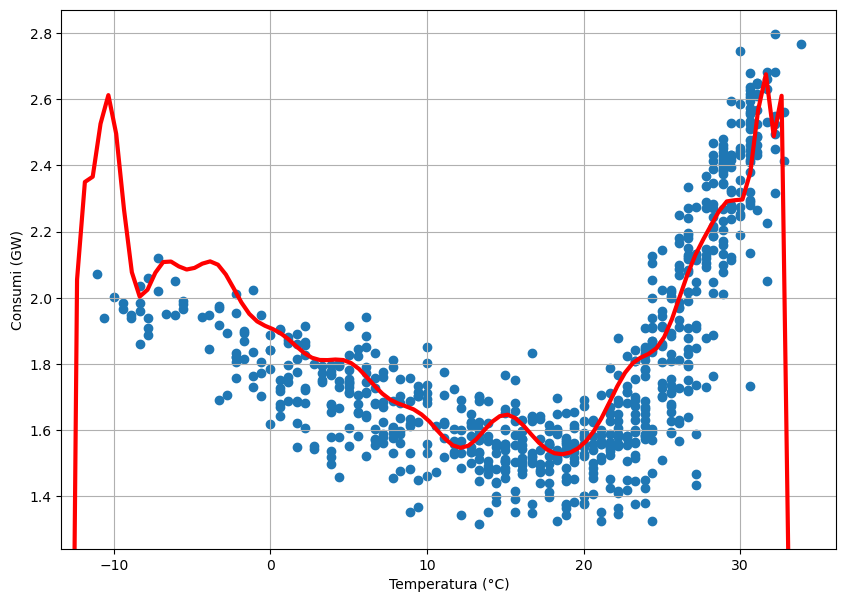

In [60]:
plot_model_on_data(X_test, y_test, prm)

Si nota che nei casi estremi del test set, diversi da quelli del training set, l'errore del modello è molto alto

Vediamo quali sono i coefficienti del modello addestrato

In [61]:
prm.named_steps["linreg"].coef_

array([-2.23745355e-01, -8.93110918e-01, -7.56698941e+01,  6.05662641e+02,
        7.03288898e+03, -5.65838654e+04, -2.48980992e+05,  2.42085088e+06,
        3.20755652e+06, -5.70784067e+07,  2.77076547e+07,  7.65951738e+08,
       -1.42433538e+09, -5.37585055e+09,  1.91837092e+10,  9.60362507e+09,
       -1.24210862e+11,  1.26456444e+11,  3.39792449e+11, -9.14047692e+11,
        2.44433060e+11,  1.95743107e+12, -3.17349781e+12,  8.81180746e+11,
        3.34527728e+12, -5.49096709e+12,  4.29570973e+12, -1.95178128e+12,
        4.96728472e+11, -5.52335763e+10])

I coefficienti per i termini di grado più alto sono molto alti in valore assoluto (fino a ${10}^{12}$), questo causa l'andamento irregolare del modello nei casi estremi e i conseguenti errori

Come evitare che i coefficienti assumano tali valori?

La **_regolarizzazione_** modifica la funzione d'errore su cui si basa l'addestramento, aggiungendo una penalità per valori estremi dei parametri del modello

Nella regolarizzazione _L2_, la più comune, la penalità è proporzionale al quadrato della norma euclidea del vettore $\mathbf{\theta}$ dei parametri: in questo modo parametri molto alti in valore assoluto sono molto penalizzati

La regressione _ridge_ consiste nella regressione lineare con applicata la regolarizzazione L2, utilizzando quindi la seguente funzione d'errore:

$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_2^2 $$

$\alpha$ è un iperparametro che controlla il "peso" della regolarizzazione: maggiore è $\alpha$, più i coefficienti saranno forzati ad avere valori piccoli

Per eseguire la regressione ridge usiamo un modello `Ridge` al posto di `LinearRegression`

Alla creazione del modello è possibile specificare il peso della regolarizzazione con l'opzione `alpha`

Per il resto l'API della classe `Ridge` è identica a quella di `LinearRegression`, possiamo quindi sostituirla nella pipeline

In [62]:
from sklearn.linear_model import Ridge

rrm = Pipeline([
    ("poly",   PolynomialFeatures(degree=30, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge(alpha=1))  # <-- sostituice LinearRegression()
])
rrm.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=30, include_bias=False)),
                ('scale', StandardScaler()), ('linreg', Ridge(alpha=1))])

Verifichiamo i coefficienti del modello addestrato

In [63]:
rrm.named_steps["linreg"].coef_

array([-0.31325676, -0.02583932,  0.16619334,  0.12873744,  0.15304114,
        0.10838303,  0.08446827,  0.04675489,  0.01952785, -0.00549028,
       -0.02267416, -0.03463496, -0.04084124, -0.0427362 , -0.04099736,
       -0.03668078, -0.03057249, -0.02344422, -0.01590952, -0.00848886,
       -0.00158713,  0.00448139,  0.00948767,  0.01327275,  0.01573763,
        0.01683213,  0.01654581,  0.01489957,  0.01193869,  0.00772681])

Vediamo che questa volta sono tutti inferiori a 1 in valore assoluto, per effetto della regolarizzazione

Con tali, coefficienti, il modello ha un comportamento regolare anche per casi estremi, come si può vedere dal grafico

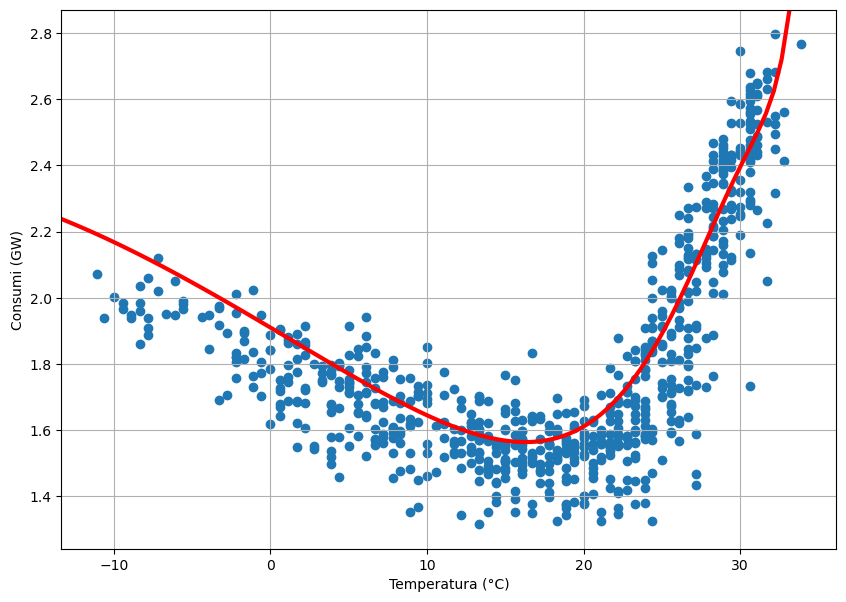

In [64]:
plot_model_on_data(X_test, y_test, rrm)

Verifichiamo l'accuratezza su training e validation set

In [65]:
print_eval(X_train, y_train, rrm)

   Mean squared error: 0.020643
       Relative error: 6.14974%
R-squared coefficient: 0.8073


In [66]:
print_eval(X_test, y_test, rrm)

   Mean squared error: 0.024567
       Relative error: 6.91874%
R-squared coefficient: 0.77102


Vediamo che le misure sul training set sono di poco peggiori, ma quelle sul test set sono nettamente migliori

### Esercizio 2: Regressione polinomiale al variare di grado e regolarizzazione

- **(2a)** Definire una funzione `test_regression` con parametri `degree` e `alpha` che
  - definisca un modello di regressione polinomiale di grado `degree` con standardizzazione dei dati e regolarizzazione L2 con peso `alpha`
  - _(già implementato)_ addestri tale modello sui dati `X_train`, `y_train`
  - _(già implementato)_ restituisca il coefficiente R² del modello calcolato sui dati `X_test`, `y_test`
- **(2b)** Generare una lista, array o serie di valori restituiti dalla funzione con `alpha=0.01` e `degree` variabile con valori da 3 a 30
- **(2c)** Ripetere il punto 2b con `alpha=10`
- **(2d)** Visualizzare i risultati in un grafico a linea (`plt.plot`)

In [70]:
# 2a
def test_regression(degree, alpha):
    rrm = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale", StandardScaler()),
        ("linreg", Ridge(alpha=alpha)),
    ])
    rrm.fit(X_train, y_train)
    return rrm.score(X_test, y_test)

In [75]:
degrees = list(range(3, 31))

In [76]:
# 2b
scores_a = [test_regression(degree, 0.01) for degree in degrees]

In [77]:
# 2c
scores_b = [test_regression(degree, 10) for degree in degrees]

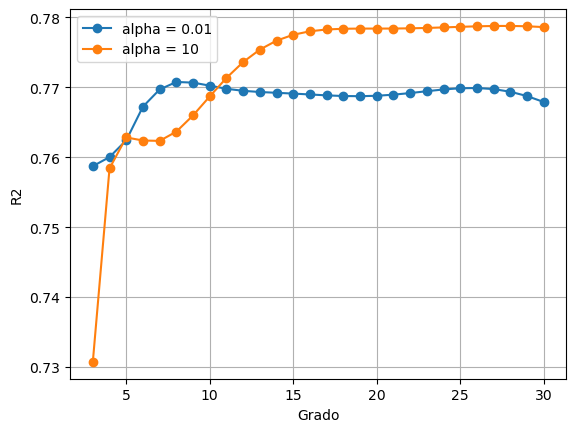

In [80]:
# 2d
plt.plot(degrees, scores_a, "-o")
plt.plot(degrees,scores_b, "-o")
plt.grid()
plt.xlabel("Grado")
plt.ylabel("R2")
plt.legend(["alpha = 0.01", "alpha = 10"])

## Caso di studio: Predizione dei prezzi delle case

Riprendiamo dalla scorsa esercitazione il dataset relativo ai prezzi delle case

Forniamo tale dataset all'URL https://git.io/fjGjx già adattato per essere caricato con `read_csv` con le opzioni di default

In [72]:
HOUSING_DATA_URL = "https://github.com/datascienceunibo/dialab2024/raw/main/Regressione_non_Lineare/housing.csv"

import os.path
if not os.path.exists("housing.csv"):
    from urllib.request import urlretrieve
    urlretrieve(HOUSING_DATA_URL, "housing.csv")

In [73]:
housing = pd.read_csv("housing.csv")

### Lista delle variabili

- CRIM: tasso di criminalità pro capite per zona
- ZN: proporzione terreno residenziale per lotti maggiori di 25.000 piedi quadrati (circa 2300 m2)
- INDUS: proporzione di acri industriali non commerciali per città
- CHAS: variabile fittizia Charles River, 1 se il tratto affianca il fiume, altrimenti 0
- NOX: concentrazione di ossido d’azoto (parti per 10 milioni)
- RM: numero medio di stanze per abitazione
- AGE: proporzione delle unità abitate costruite prima del 1940
- DIS: distanze pesate verso i cinque uffici di collocamento di Boston
- RAD: indice di accessibilità rispetto alle grandi vie radiali di comunicazione
- TAX: tasso di imposte sulla casa per 10.000 dollari
- PTRATIO: rapporto allievi-docenti per città
- B: 1000(Bk - 0.63)2, dove Bk è la proporzione di persone di origine afroamericana
- LSTAT: percentuale di popolazione con basso reddito
- **MEDV: valore mediano delle abitazioni di proprietà in migliaia di dollari**
  - vogliamo stimare il valore di questa variabile in funzione delle altre

In [ ]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Estraiamo dal frame

- la serie `y` con i valori della variabile `MEDV` da prevedere
- il frame `X` con i valori di tutte le altre variabili, utilizzabili per la predizione

In [81]:
y = housing["MEDV"]
X = housing.drop(columns="MEDV")

Dividiamo i dati caricati casualmente in training e test set con la funzione `train_test_split`

- con `test_size` indichiamo quanti dati vanno nel test set, i restanti andranno nel training set
- con `random_state` fissiamo un seed per la suddivisione casuale
- la funzione mescola i dati di `X` e `y` in modo congiunto, mantenendo la corrispondenza esistente tra le posizioni dei dati

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=1/3, random_state=42)

### Esercizio 3: Valutazione modelli con regolarizzazione/standardizzazione

Addestrare sul training set e stampare le metriche di valutazione sul test set di...

- **(a)** un modello `model_a` di regressione lineare semplice
- **(b)** un modello `model_b` di regressione lineare con regolarizzazione L2 (regressione ridge), assumendo $\alpha=1$
- **(c)** un modello `model_c` di regressione lineare con standardizzazione delle feature

In [83]:
# 3a
model_a = LinearRegression()
model_a.fit(X_train, y_train)
print_eval(X_test, y_test, model_a)

   Mean squared error: 20.595
       Relative error: 16.20789%
R-squared coefficient: 0.72621


In [89]:
# 3b
model_b = Ridge(alpha=1)
model_b.fit(X_train, y_train)
print_eval(X_test, y_test, model_b)

   Mean squared error: 20.989
       Relative error: 16.23286%
R-squared coefficient: 0.72097


In [87]:
# 3c
model_c = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", LinearRegression())
])
model_c.fit(X_train, y_train)
print_eval(X_test, y_test, model_c)

   Mean squared error: 20.595
       Relative error: 16.20789%
R-squared coefficient: 0.72621


### Analisi coefficienti dei modelli

Visualizziamo ora in un unico frame i coefficienti di tutti e tre i modelli (una riga per variabile, una colonna per modello)

In [92]:
pd.DataFrame({
    "linear": model_a.coef_,
    "ridge": model_b.coef_,
    "scaled": model_c.named_steps["linreg"].coef_
}, index=X.columns)

,linear,ridge,scaled
CRIM,-0.129470,-0.123146,-0.995690
ZN,0.037960,0.038976,0.872971
INDUS,0.060978,0.025082,0.424808
CHAS,3.213498,3.002536,0.857462
NOX,-16.499614,-8.194944,-1.943856
RM,3.911519,3.916200,2.820988
AGE,-0.012602,-0.019499,-0.351939
DIS,-1.427742,-1.304313,-3.063072
RAD,0.239546,0.220686,2.069621
TAX,-0.008180,-0.008956,-1.356887


In tutti e tre i modelli, dai segni dei coefficienti possiamo vedere quali fenomeni influiscono positivamente e negativamente sul prezzo

Ad esempio il prezzo delle case è più alto se vicine al fiume (`CHAS`), mentre decresce con la criminalità (`CRIM`)

Nella regressione ridge i valori assoluti più alti sono ridotti (es. `NOX` e `RM`)

Con la standardizzazione delle feature otteniamo valori su scale simili, che possiamo confrontare alla pari

Ad esempio negli altri modelli il coefficiente di `NOX` è alto in valore assoluto perché i valori di tale variabile sono bassi (la media è circa 0.55, contro quelle superiori a 3 delle altre variabili)

Nel modello con standardizzazione appaiono invece più importanti il numero di stanze (`RM`) e la distanza dagli uffici di collocamento (`DIS`)

## Regressione Lasso

La regolarizzazione L2 vista sopra impedisce che i parametri del modello assumano valori troppo alti

I valori dei parametri sono comunque tutti non nulli, tutte le variabili vengono coinvolte nella predizione

Vorremmo addestrare un modello meno complesso, dove alcuni parametri hanno valori nulli, **ignorando completamente le variabili meno rilevanti**, incluse ad es. variabili con valori dipendenti da altre (_multicollinearità_)

Questo si può ottenere tramite la regolarizzazione L1, basata sulla norma 1, definita su un vettore $\mathbf{x}$ di $n$ elementi come

$$ \left\Vert\mathbf{x}\right\Vert_1 = \sum_{i=1}^n{\left\vert x_i\right\vert} = \left\vert x_1\right\vert+\ldots+\left\vert x_n\right\vert $$

La regressione _lasso_ consiste nella regressione lineare con regolarizzazione L1, basata quindi sul minimizzare la funzione d'errore

$$ E = \frac{1}{2m}\left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_1 $$

Come per la regressione ridge, il parametro $\alpha$ controlla il peso della regolarizzazione

La regressione lasso si esegue usando un modello `Lasso`, su cui possiamo impostare come in `Ridge` il parametro `alpha`

In [93]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=1))
])
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('regr', Lasso(alpha=1))])

Vediamo i coefficienti del modello risultante

In [94]:
pd.Series(model.named_steps["regr"].coef_, X.columns)

CRIM      -0.000000
ZN         0.000000
INDUS     -0.000000
CHAS       0.270752
NOX       -0.000000
RM         2.641503
AGE       -0.000000
DIS       -0.000000
RAD       -0.000000
TAX       -0.000000
PTRATIO   -1.200172
B          0.311046
LSTAT     -3.814854
dtype: float64

La regolarizzazione L1 ha contribuito ad annullare quanti più coefficienti possibile, creando un modello che considera solo 5 variabili

Ma qual'è l'accuratezza di tale modello?

In [ ]:
print_eval(X_test, y_test, model)

   Mean squared error: 25.984
       Relative error: 19.41638%
R-squared coefficient: 0.65457


L'accuratezza è peggiore rispetto ai casi precedenti: in questo caso la regolarizzazione è stata eccessiva

Cosa succede diminuendo il parametro `alpha`, ovvero il peso della regolarizzazione?

In [95]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=0.2)) # <-- cambiato da 1
])
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('regr', Lasso(alpha=0.2))])

In [ ]:
pd.Series(model.named_steps["regr"].coef_, X.columns)

CRIM      -0.394705
ZN         0.192948
INDUS     -0.000000
CHAS       0.827011
NOX       -0.812358
RM         2.944153
AGE       -0.000000
DIS       -1.514910
RAD        0.000000
TAX       -0.000000
PTRATIO   -1.698942
B          0.842742
LSTAT     -4.009724
dtype: float64

I coefficienti non nulli sono aumentati da 5 a 9

In [ ]:
print_eval(X_test, y_test, model)

   Mean squared error: 22.527
       Relative error: 16.62391%
R-squared coefficient: 0.70053


L'accuratezza è di poco inferiore a quella ottenuta con gli altri modelli

Questo modello richiede però solo 9 variabili invece di 13

## Elastic Net

La regressione _elastic net_ combina insieme le regolarizzazioni L2 e L1 usate in ridge e lasso

Si applica in scikit-learn tramite la classe `ElasticNet`, per cui l'errore è calcolato come:

$$ E = \underbrace{\frac{1}{2m} ||X\theta - y||_2 ^ 2}_{\text{errore sui dati}} + \underbrace{\alpha \rho ||\theta||_1}_{\text{L1}} + \underbrace{\frac{\alpha(1-\rho)}{2} ||\theta||_2 ^ 2}_{\text{L2}} $$

I parametri impostabili sono

- `alpha` ($\alpha$) che determina il peso generale della regolarizzazione
- `l1_ratio` ($\rho$, compreso tra 0 e 1) che determina il peso di L1 relativo al totale (con $\rho=1$ si ha la regressione lasso, con $\rho=0$ la ridge)

In [96]:
from sklearn.linear_model import ElasticNet
model = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
model.fit(X_train, y_train)
print_eval(X_test, y_test, model)

   Mean squared error: 22.092
       Relative error: 16.18298%
R-squared coefficient: 0.70631


### Esercizio 4: Elastic Net con pesi separati

- **(4a)** Definire una funzione `elastic_net_with_alphas` che restituisca un modello `ElasticNet` (non addestrato) con pesi dati separatamente per la regolarizzazione L2 e L1
  - si ricordi che il parametro `alpha` è la somma dei due pesi
- **(4b)** Servendosi di tale funzione, addestrare e validare un modello elastic net con $\alpha_{L2}=1, \alpha_{L1}=0.1$ e standardizzazione delle feature

In [97]:
# 4a
def elastic_net_with_alphas(alpha_l2, alpha_l1):
    alpha = alpha_l1 + alpha_l2
    l1_ratio = alpha_l1 / alpha
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

In [99]:
# 4b
model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", elastic_net_with_alphas(1, 0.1))
])
model.fit(X_train, y_train)
print_eval(X_test, y_test, model)

   Mean squared error: 28.122
       Relative error: 18.96992%
R-squared coefficient: 0.62615


## Regressione polinomiale multivariata

Abbiamo visto in precedenza la regressione polinomiale su una sola variabile $X$ (univariata), corrispondente alla regressione lineare sulle variabili $X,X^2,X^3,\ldots$

Per generare queste variabili utilizziamo il filtro `PolynomialFeatures`

Siano date ad esempio due osservazioni di una variabile...

In [100]:
sample = np.array([ [ 2],
                    [-3] ])

Possiamo ottenere ad es. le potenze fino al 4° grado (`include_bias=True` specifica di non includere il termine di grado 0)

In [101]:
poly = PolynomialFeatures(degree=4, include_bias=False)
poly.fit_transform(sample)
#         X   X^2   X^3   X^4

array([[  2.,   4.,   8.,  16.],
       [ -3.,   9., -27.,  81.]])

In presenza di più di una variabile, la regressione polinomiale genera tutti i possibili termini fino al grado impostato, includendo anche **termini basati su più variabili**

Vediamo un esempio con 2 generiche variabili $A$ e $B$

In [102]:
#                     A   B
sample = np.array([ [ 2, -3],
                    [ 4, -5] ])

Applicando il filtro `PolynomialFeatures` con grado 2...

In [103]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(sample)
#         A     B    A^2   A*B   B^2

array([[  2.,  -3.,   4.,  -6.,   9.],
       [  4.,  -5.,  16., -20.,  25.]])

Le variabili generate sono 5: $A,B,A^2,AB,B^2$

Oltre ai quadrati delle singole variabili abbiamo quindi anche i prodotti tra di esse

Possiamo usare il metodo `get_feature_names_out` del filtro per avere un array delle variabili calcolate _(`get_feature_names` in versioni più vecchie di scikit-learn)_

- il filtro deve già essere stato "addestrato" con `fit` o `fit_transform`
- è possibile passare una lista di nomi delle variabili originali, altrimenti sono usati `x0`, `x1`, ...

In [104]:
poly.get_feature_names_out()

array(['x0', 'x1', 'x0^2', 'x0 x1', 'x1^2'], dtype=object)

In [105]:
poly.get_feature_names_out(["A", "B"])

array(['A', 'B', 'A^2', 'A B', 'B^2'], dtype=object)

Aumentando il grado massimo, le variabili generate **aumentano rapidamente**

Ad esempio, aumentando il grado da 2 a 3...

In [106]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(sample)

array([[   2.,   -3.,    4.,   -6.,    9.,    8.,  -12.,   18.,  -27.],
       [   4.,   -5.,   16.,  -20.,   25.,   64.,  -80.,  100., -125.]])

...generiamo 9 variabili, ovvero:

In [107]:
poly.get_feature_names_out(["A", "B"])

array(['A', 'B', 'A^2', 'A B', 'B^2', 'A^3', 'A^2 B', 'A B^2', 'B^3'],
      dtype=object)

Cosa succede con un numero iniziale di variabili più alto?

Selezioniamo ad esempio dalle variabili X del dataset `housing` le 5 feature che avevano coefficiente non nullo nella prima regressione Lasso

In [108]:
# la lista delle feature da considerare è:
Xsub_feats = ["CHAS", "RM", "PTRATIO", "B", "LSTAT"]
# creo una selezione sia dal training che dal validation set
Xsub_train = X_train[Xsub_feats]
Xsub_test = X_test[Xsub_feats]
# stampo il numero di colonne
Xsub_train.shape[1]

5

Generando le feature polinomiali con grado massimo 2...

In [109]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(Xsub_train).shape[1]

20

...otteniamo 20 feature distinte!

Le feature includono infatti tutte le possibili coppie di variabili, oltre ai quadrati di ciascuna

In [110]:
poly.get_feature_names_out(Xsub_train.columns)

array(['CHAS', 'RM', 'PTRATIO', 'B', 'LSTAT', 'CHAS^2', 'CHAS RM',
       'CHAS PTRATIO', 'CHAS B', 'CHAS LSTAT', 'RM^2', 'RM PTRATIO',
       'RM B', 'RM LSTAT', 'PTRATIO^2', 'PTRATIO B', 'PTRATIO LSTAT',
       'B^2', 'B LSTAT', 'LSTAT^2'], dtype=object)

È possibile in alternativa generare solamente le feature derivate dalla moltiplicazione ("interazione") di variabili diverse (escludendo quindi i quadrati) impostando `interaction_only=True`

In [111]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly.fit_transform(Xsub_train).shape[1]

15

In [112]:
poly.get_feature_names_out(Xsub_train.columns)

array(['CHAS', 'RM', 'PTRATIO', 'B', 'LSTAT', 'CHAS RM', 'CHAS PTRATIO',
       'CHAS B', 'CHAS LSTAT', 'RM PTRATIO', 'RM B', 'RM LSTAT',
       'PTRATIO B', 'PTRATIO LSTAT', 'B LSTAT'], dtype=object)

Aumentando ulteriormente il grado, il numero di variabili cresce esponenzialmente

In [113]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(Xsub_train).shape[1]

55

In [114]:
poly = PolynomialFeatures(degree=4, include_bias=False)
poly.fit_transform(Xsub_train).shape[1]

125

In [115]:
# usiamo un ciclo for per testare rapidamente valori successivi
for degree in range(3, 9):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    feats_count = poly.fit_transform(Xsub_train).shape[1]
    print(f"{degree}° grado: {feats_count} variabili")

3° grado: 55 variabili
4° grado: 125 variabili
5° grado: 251 variabili
6° grado: 461 variabili
7° grado: 791 variabili
8° grado: 1286 variabili


Questa crescita è ancora più evidente con la matrice completa `X_train`, con 13 variabili

In [118]:
X_train.shape[1]

13

Generando le feature polinomiali con grado massimo 2 otteniamo 104 feature

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(X_train).shape[1]

104

Aumentando ulteriormente il grado, il numero di variabili cresce enormemente (con grado 10 si supera il milione di variabili!)

In [ ]:
for degree in range(3, 8):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    feats_count = poly.fit_transform(X_train).shape[1]
    print(f"{degree}° grado: {feats_count} variabili")

3° grado: 559 variabili
4° grado: 2379 variabili
5° grado: 8567 variabili
6° grado: 27131 variabili
7° grado: 77519 variabili


All'aumentare delle variabili, aumenta il tempo necessario per l'addestramento del modello

Prendiamo ad esempio come riferimento un modello ElasticNet polinomiale con standardizzazione delle feature generate

Creiamo una funzione che crea tale modello con la possibilità di impostare il grado delle feature generate

In [116]:
def poly_std_elasticnet(degree):
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("std",  StandardScaler()),
        ("regr", ElasticNet(alpha=0.5, l1_ratio=0.2))
    ])

Eseguiamo la prova su un modello di grado 2 per predire il prezzo delle case col sottoinsieme di 5 feature indicato sopra

Usiamo il comando "magico" `%time` per riportare in output il tempo di esecuzione

In [117]:
model = poly_std_elasticnet(2)
%time model.fit(Xsub_train, y_train)
print_eval(Xsub_test, y_test, model)

CPU times: total: 0 ns
Wall time: 4.99 ms
   Mean squared error: 22.74
       Relative error: 17.05512%
R-squared coefficient: 0.69769


### Esercizio 5: Regressione polinomiale con molte variabili

Usando la funzione `poly_std_elaticnet` definita sopra per configurare i modelli, addestrare sul training set misurando il tempo necessario con `%time` e valutare l'accuratezza sul test set di:

- **(5a)** un modello di grado 2 su tutte le feature
- **(5b)** un modello di grado 5 sul sottoinsieme di 5 feature
- **(5c)** un modello di grado 5 su tutte le feature

In [119]:
# 5a
model_a = poly_std_elasticnet(2)
%time model_a.fit(X_train, y_train)
print_eval(X_test, y_test, model_a)

CPU times: total: 0 ns
Wall time: 17.5 ms
   Mean squared error: 19.854
       Relative error: 15.44921%
R-squared coefficient: 0.73606


In [120]:
# 5b
model_b = poly_std_elasticnet(5)
%time model_b.fit(Xsub_train, y_train)
print_eval(Xsub_test, y_test, model_b)

CPU times: total: 31.2 ms
Wall time: 53.1 ms
   Mean squared error: 16.714
       Relative error: 14.62323%
R-squared coefficient: 0.7778


In [122]:
# 5c
model_c = poly_std_elasticnet(5)
%time model_c.fit(X_train, y_train)
print_eval(X_test, y_test, model_c)

CPU times: total: 672 ms
Wall time: 1.2 s
   Mean squared error: 11.969
       Relative error: 11.63031%
R-squared coefficient: 0.84089


c:\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e+02, tolerance: 2.977e+00
  model = cd_fast.enet_coordinate_descent(


Dagli esercizi emerge che l'accuratezza del modello migliora sensibilmente, ma **con tempi di addestramento molto superiori**

- più di 10 volte superiori con 5 feature
- più di 100 volte superiori con 13 feature

Con dataset più grandi, avremmo tempi di addestramento insostenibili

## Regressione con funzioni kernel

Nella regressione polinomiale si eseguono prodotti tra dati con dimensioni aggiunte e rappresentate esplicitamente

Le _funzioni kernel_ permettono di calcolare gli stessi prodotti senza calcolare esplicitamente le dimensioni aggiunte

Questo permette di ottenere **modelli non lineari senza l'aggiunta di variabili**

Esistono diverse funzioni kernel utilizzabili con diversi parametri impostabili

Ad esempio, il kernel polinomiale è definito dalla formula

$$ K(\mathbf{a},\mathbf{b}) = \left(\mathbf{a}\cdot\mathbf{b}+c\right)^d $$

$d$ e $c$ sono parametri del kernel, in particolare $d$ è il grado del polinomio

La classe `KernelRidge` implementa la regressione ridge con l'applicazione di una funzione kernel

Col parametro `kernel` si indica il tipo di kernel con una stringa, ad es. `"poly"` per un kernel polinomiale

Ulteriori parametri riguardano il kernel, per quello polinomiale sono `degree` ($d$) e `coef0` ($c$)

In [123]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])
%time model.fit(X_train, y_train)
print_eval(X_test, y_test, model)

CPU times: total: 0 ns
Wall time: 37.5 ms
   Mean squared error: 14.765
       Relative error: 13.09973%
R-squared coefficient: 0.80371


Abbiamo ottenuto un'accuratezza più elevata rispetto ai modelli lineari, ma in tempi molto più brevi rispetto alla regressione polinomiale

Aumentando arbitrariamente il grado del polinomio, il tempo impiegato per l'addestramento non cambia (in questo caso comunque un grado alto non porta ad un modello accurato)

In [124]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=15))
])
%time model.fit(X_train, y_train)
print_eval(X_test, y_test, model)

CPU times: total: 0 ns
Wall time: 9 ms
   Mean squared error: 2.0188e+07
       Relative error: 8417.85655%
R-squared coefficient: -2.6838e+05


Va però ricordato che la complessità cresce quadraticamente col numero di istanze di training

Ad esempio, addestrando un modello su _tutti_ i dati invece che sul solo training set, quindi sul 50\% di istanze in più...

In [125]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])
%time model.fit(X, y)
print_eval(X_test, y_test, model)

CPU times: total: 0 ns
Wall time: 13 ms
   Mean squared error: 8.2617
       Relative error: 8.99352%
R-squared coefficient: 0.89017


... il tempo necessario è circa il doppio

Possiamo testare anche funzioni kernel diverse, ad esempio RBF (_radial basis function_)

RBF ha valori tanto più elevati quanto più i valori X sono vicini a 0 (ovvero la media, usando dati standardizzati)

La funzione RBF ha la forma di una gaussiana, di cui si può impostare l'ampiezza col parametro `gamma`

In [126]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="rbf", gamma=0.01))
])
%time model.fit(X_train, y_train)
print_eval(X_test, y_test, model)

CPU times: total: 0 ns
Wall time: 6.51 ms
   Mean squared error: 43.906
       Relative error: 19.38425%
R-squared coefficient: 0.41632


In questo caso specifico il kernel RBF non funziona bene tanto quanto il polinomiale

## k-Fold Cross Validation

La _cross validation_ si riferisce in generale alla valutazione di un modello di predizione su dati differenti rispetto a quelli su cui è addestrato

La cross validation prevede in generale di generare diverse suddivisioni dei dati in _training set_ e _validation set_ e per ciascuna addestrare un modello sul primo e misurare le metriche di accuratezza sul secondo

Finora abbiamo usato il semplice metodo _hold-out_, dove viene effettuata una singola suddivisione dei dati con proporzioni configurabili

_k-fold_ è un metodo comune per eseguire una valutazione più accurata del modello

- i dati sono divisi causalmente in k gruppi (_fold_)
- ciascun gruppo è usato come test set di un modello addestrato su tutti gli altri gruppi
- i risultati dei singoli test sono aggregati

scikit-learn fornisce un supporto generico per la cross-validation di modelli tramite diversi metodi

Per prima cosa va creato un oggetto che definisce il metodo di cross-validation da applicare

Usiamo ad esempio un oggetto della classe `KFold`

- il primo parametro è il numero di fold (k) da usare
- specifichiamo inoltre che i dati sono distribuiti casualmente e il seed da usare

In [127]:
from sklearn.model_selection import KFold
kfold_5 = KFold(5, shuffle=True, random_state=42)

Gli oggetti di questo tipo forniscono un metodo `split`, che dato un dataset genera le suddivisioni training/test secondo la configurazione data

Per ogni suddivisione sono dati un array di etichette delle righe da includere nel training set (`train_index`) e l'array complementare di etichette delle righe da includere nel validation set (`val_index`)

In [128]:
for i, (train_index, val_index) in enumerate(kfold_5.split(X, y), start=1):
    print(f"Fold {i}: {len(train_index)} istanze di training, {len(val_index)} istanze di validazione")
    # per ottenere ad es. X_train: X[train_index]

Fold 1: 404 istanze di training, 102 istanze di validazione
Fold 2: 405 istanze di training, 101 istanze di validazione
Fold 3: 405 istanze di training, 101 istanze di validazione
Fold 4: 405 istanze di training, 101 istanze di validazione
Fold 5: 405 istanze di training, 101 istanze di validazione


Definiamo la configurazione di un modello da validare, ad es. il modello kernel ridge visto sopra

In [129]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])

Per eseguire la CV usiamo quindi la funzione `cross_validate`, a cui passiamo in input:

- la definizione di un modello, di cui viene addestrata una copia con la stessa configurazione per ciascun fold
- i dati, divisi come per `fit` in valori di variabili indipendenti (X) e dipendente (y)
- un oggetto `cv` che definisce il metodo di cross validation, in questo caso l'istanza di `KFold`
- l'opzione `return_train_score=True` per eseguire la valutazione anche sui training set

In [130]:
from sklearn.model_selection import cross_validate
cv_result = cross_validate(model, X, y, cv=kfold_5, return_train_score=True)

Otteniamo un dizionario con un vettore per ciascuna misura estratta, ciascuno ha un valore per ogni fold

In [ ]:
cv_result

{'fit_time': array([0.13398695, 0.01795316, 0.1197207 , 0.11664462, 0.11166668]),
 'score_time': array([0.01694465, 0.02672505, 0.03503299, 0.10914445, 0.01905942]),
 'test_score': array([0.79093529, 0.83709349, 0.69734727, 0.90845112, 0.7917183 ]),
 'train_score': array([0.91333254, 0.90350452, 0.90330007, 0.8981712 , 0.90764729])}

Per maggiore comodità raccogliamo i dati in un DataFrame

In [ ]:
cv_table = pd.DataFrame(cv_result)
cv_table

,fit_time,score_time,test_score,train_score
0,0.133987,0.016945,0.790935,0.913333
1,0.017953,0.026725,0.837093,0.903505
2,0.119721,0.035033,0.697347,0.903300
3,0.116645,0.109144,0.908451,0.898171
4,0.111667,0.019059,0.791718,0.907647


Per ognuno dei 5 fold vediamo riportati

- i secondi impiegati per l'addestramento (`fit_time`) e la validazione (`score_time`) del modello
- il punteggio calcolato su training set (`train_score`) e validation set (`test_score`)

Il punteggio è quello calcolato dal metodo `score` del modello, ovvero il coefficiente R²

Per avere un dato generale sulla bontà del modello, possiamo calcolare media e deviazione standard dei punteggi

In [ ]:
cv_table[["train_score", "test_score"]].agg(["mean", "std"])

,train_score,test_score
mean,0.905191,0.805109
std,0.005657,0.076967


Tale valutazione è più affidabile di quella col metodo hold-out, ottenuta da un singolo modello

Ci permette inoltre di valutare la "robustezza" del modello, ovvero quanto l'accuratezza sia stabile addestrandosi su set di dati diversi

### Esercizio 6: Cross-validation su modello kernel ridge

- **(6a)** Definire un modello di regressione kernel ridge su feature standardizzate con kernel polinomiale di 3° grado e $\alpha=10$
- **(6b)** Eseguire la cross-validation del modello, utilizzando 5 fold dell'intero dataset `housing` (`X` e `y`) generati dall'oggetto `kfold_5` definito sopra
- **(6c)** Calcolare la media e la deviazione standard dei punteggi R² ottenuti dalla validazione di ciascun fold

In [134]:
# 6a
model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", KernelRidge(alpha=10, kernel="poly", degree=3))
])

In [135]:
# 6b
cv_res = cross_validate(model, X, y, cv=kfold_5)

In [141]:
# 6c
print("Mean = ", cv_res["test_score"].mean())
print("Std = ", cv_res["test_score"].std())

Mean =  0.8382685697714585
Std =  0.0509234697845737


## Ricerca degli iperparametri con grid search

Sui modelli utilizzati finora abbiamo impostato manualmente i valori di diversi iperparametri: grado della regressione polinomiale, peso della regolarizzazione, ...

L'accuratezza del modello può dipendere fortemente da questi valori

Scelto un generico modello da utilizzare (es. regressione polinomiale o kernel ridge), vorremmo **individuare i valori degli iperparametri che ne massimizzino l'accuratezza**

scikit-learn fornisce un supporto per eseguire automaticamente la cross validation di un modello con diversi valori degli iperparametri tramite la _grid search_

Consideriamo ad esempio un modello _elastic net_ di cui fissiamo arbitrariamente l'iperparametro `l1_ratio`

In [142]:
model = ElasticNet(l1_ratio=0.2)

Vorremmo trovare il migliore valore possibile dell'iperparametro `alpha` tra un insieme di valori possibili, ovvero:

In [143]:
candidate_alphas = [0.1, 1, 10]

Creiamo una _griglia_ degli iperparametri, ovvero un dizionario in cui associamo ai nomi degli iperparametri variabili i valori che possono assumere

In questo caso abbiamo un unico parametro variabile, `alpha`

In [144]:
grid = {"alpha": candidate_alphas}

Definiamo ora un modello `GridSearchCV` indicando

- il modello "base" con i parametri fissati a priori
- la griglia dei parametri variabili
- un metodo `cv` di cross validation da usare

In [145]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, grid, cv=kfold_5)

Come per i modelli base, usiamo il metodo `fit` per eseguire l'addestramento, passando la matrice X e il vettore y

Per ogni valore possibile di `alpha`, scikit-learn esegue la cross-validation per calcolare il punteggio R² medio del modello con quel valore di `alpha`

In [146]:
gs.fit(X_train, y_train);

In seguito ai test, il modello impostato viene (di default) riaddestrato su tutti i dati forniti, usando gli iperparametri che han dato il miglior punteggio medio

Il modello finale è accessibile all'attributo `gs_best_estimator_`

In [147]:
gs.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.2)

Dall'attributo `best_params_` possiamo vedere quali sono i valori selezionati dalla griglia degli iperparametri per tale modello

In [148]:
gs.best_params_

{'alpha': 0.1}

L'oggetto `GridSearchCV` addestrato può essere usato come un normale modello di predizione, le chiamate a `predict` e altri metodi sono girate al `best_estimator_`

In [149]:
# prezzo predetto per la prima riga del dataset
gs.predict(X.iloc[[0]])

array([31.03112487])

In [150]:
# equivalente a
gs.best_estimator_.predict(X.iloc[[0]])

array([31.03112487])

Possiamo infine valutare il modello sul test set, non utilizzato nella grid search

In [ ]:
print_eval(X_test, y_test, gs)

   Mean squared error: 21.905
       Relative error: 16.80121%
R-squared coefficient: 0.7088


L'attributo `cv_results_` fornisce risultati dettagliati su tutti gli iperparametri testati

Come per `cross_validate`, raccogliamo i risultati in un `DataFrame` per visualizzarli meglio

In [151]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002199,0.000394,0.001403,0.000489,0.1,{'alpha': 0.1},0.727252,0.496850,0.637157,0.721205,0.800228,0.676539,0.103639,1
1,0.001598,0.000494,0.000700,0.000600,1,{'alpha': 1},0.714022,0.523966,0.594603,0.670194,0.761741,0.652905,0.084740,2
2,0.001000,0.000005,0.001000,0.000001,10,{'alpha': 10},0.624769,0.373641,0.572294,0.539693,0.623149,0.546709,0.092296,3


I dati riportati per ciascun test includono:
- `{mean|std}_{fit|score}_time`: media/dev. standard dei tempi di addestramento/valutazione sui diversi fold
- `param_X`: valore del parametro X
- `params`: dizionario col valore di tutti i parametri
- `splitN_test_score`: punteggio della valutazione sull'N-esimo fold
- `{mean|std}_test_score`: media/dev. standard dei punteggi sui diversi fold
- `rank_test_score`: ranking del punteggio, 1 è il migliore

Cosa succede con due iperparametri variabili?

Oltre a 3 valori possibili per `alpha`, impostiamo 3 valori possibili anche per `l1_ratio`

In [152]:
model = ElasticNet()
grid = {
    "alpha":    [0.1, 1, 10],
    "l1_ratio": [0.1, 0.2, 0.3]
}
gs = GridSearchCV(model, grid, cv=kfold_5)
gs.fit(X_train, y_train);

Visualizzo i risultati ordinati per punteggio R² medio decrescente

In [153]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002034,0.000635,0.000965,0.000076,0.1,0.1,"{'alpha': 0.1, 'l1_ratio': 0.1}",0.727791,0.499753,0.636757,0.721171,0.800223,0.677139,0.102714,1
1,0.001500,0.000446,0.001002,0.000003,0.1,0.2,"{'alpha': 0.1, 'l1_ratio': 0.2}",0.727252,0.496850,0.637157,0.721205,0.800228,0.676539,0.103639,2
2,0.001503,0.000444,0.000800,0.000400,0.1,0.3,"{'alpha': 0.1, 'l1_ratio': 0.3}",0.726624,0.493642,0.637503,0.721081,0.800186,0.675807,0.104646,3
3,0.001001,0.000003,0.001102,0.000202,1,0.1,"{'alpha': 1, 'l1_ratio': 0.1}",0.714960,0.526437,0.595148,0.670794,0.763423,0.654152,0.084507,4
4,0.002201,0.000749,0.001108,0.000219,1,0.2,"{'alpha': 1, 'l1_ratio': 0.2}",0.714022,0.523966,0.594603,0.670194,0.761741,0.652905,0.084740,5
5,0.001673,0.000579,0.000963,0.000073,1,0.3,"{'alpha': 1, 'l1_ratio': 0.3}",0.714237,0.521933,0.594699,0.669538,0.759777,0.652037,0.084850,6
6,0.001303,0.000404,0.000403,0.000494,10,0.1,"{'alpha': 10, 'l1_ratio': 0.1}",0.638007,0.397883,0.577252,0.557198,0.655982,0.565264,0.091374,7
7,0.000985,0.000601,0.000852,0.000429,10,0.2,"{'alpha': 10, 'l1_ratio': 0.2}",0.624769,0.373641,0.572294,0.539693,0.623149,0.546709,0.092296,8
8,0.001063,0.000120,0.000599,0.000489,10,0.3,"{'alpha': 10, 'l1_ratio': 0.3}",0.614417,0.357906,0.570172,0.529856,0.607627,0.535995,0.094024,9


scikit-learn ha generato e testato **tutte le combinazioni possibili** dei valori degli iperparametri, in tutto 3×3 = 9 configurazioni

### Grid search su pipeline

Possiamo usare `GridSearchCV` anche con una pipeline testando diversi valori per gli iperparametri di tutti i componenti, sia modello che filtri

Consideriamo ad esempio il seguente modello polinomiale con regolarizzazione L2, su cui sono variabili

- il grado del polinomio (attributo `degree` del filtro `poly`)
- il peso della regolarizzazione (attributo `alpha` del modello `regr`)

In [154]:
model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  Ridge())
])

Per riferirsi ai parametri dei singoli componenti, usiamo la notazione `componente__parametro` _(con DUE underscore in mezzo)_

In [155]:
grid = {
    # grado polinomio (parametro "degree" del filtro "poly")
    "poly__degree": [2, 3],
    # peso regolarizzazione (parametro "alpha" del modello "regr")
    "regr__alpha":  [0.1, 1, 10],
}

Il resto del procedimento rimane invariato

In [156]:
gs = GridSearchCV(model, grid, cv=kfold_5)
gs.fit(X_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_regr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.002656,0.000426,0.001141,0.000444,2,1,"{'poly__degree': 2, 'regr__alpha': 1}",0.835447,0.596491,0.802240,0.810611,0.882463,0.785450,0.098521,1
2,0.005976,0.002786,0.001806,0.001718,2,10,"{'poly__degree': 2, 'regr__alpha': 10}",0.842239,0.594859,0.750900,0.795789,0.856246,0.768007,0.094172,2
0,0.005009,0.001140,0.001402,0.000485,2,0.1,"{'poly__degree': 2, 'regr__alpha': 0.1}",0.824409,0.648065,0.850516,0.816894,0.493138,0.726604,0.136929,3
5,0.006419,0.000882,0.001390,0.000502,3,10,"{'poly__degree': 3, 'regr__alpha': 10}",0.853895,0.454814,0.773790,0.748621,0.333358,0.632895,0.201753,4
4,0.006182,0.000788,0.001806,0.000399,3,1,"{'poly__degree': 3, 'regr__alpha': 1}",0.852441,0.568150,0.794898,0.775824,-3.047350,-0.011207,1.521113,5
3,0.007433,0.001221,0.001331,0.000591,3,0.1,"{'poly__degree': 3, 'regr__alpha': 0.1}",0.692042,0.664729,0.648950,0.784034,-3.348237,-0.111696,1.618947,6


Nella pipeline possiamo impostare un intero componente come parametro variabile, con la possibilità di rimuoverlo impostandolo a `None`

Possiamo ad esempio testare un modello con e senza standardizzazione delle feature

In [ ]:
model = Pipeline([
    ("scale", None),   # uso None come segnaposto
    ("regr",  Ridge())
])
grid = {
    # scale = standardizzazione oppure nulla
    "scale": [None, StandardScaler()],
    "regr__alpha": [0.1, 1, 10]
}
gs = GridSearchCV(model, grid, cv=kfold_5)
gs.fit(X_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__alpha,param_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.001607,0.000310,0.000609,0.000060,1,StandardScaler(),"{'regr__alpha': 1, 'scale': StandardScaler()}",0.735767,0.495302,0.657167,0.720101,0.800925,0.681853,0.103883,1
1,0.002227,0.000228,0.000820,0.000101,0.1,StandardScaler(),"{'regr__alpha': 0.1, 'scale': StandardScaler()}",0.735121,0.495993,0.656523,0.720110,0.801136,0.681776,0.103648,2
5,0.001399,0.000083,0.000624,0.000067,10,StandardScaler(),"{'regr__alpha': 10, 'scale': StandardScaler()}",0.741449,0.487396,0.662300,0.718528,0.798668,0.681668,0.106525,3
0,0.003799,0.003534,0.001123,0.000211,0.1,None,"{'regr__alpha': 0.1, 'scale': None}",0.734675,0.494498,0.655446,0.718577,0.801852,0.681009,0.104244,4
2,0.000849,0.000045,0.000518,0.000039,1,None,"{'regr__alpha': 1, 'scale': None}",0.730686,0.487010,0.649269,0.712555,0.801934,0.676291,0.106412,5
4,0.000928,0.000177,0.000654,0.000116,10,None,"{'regr__alpha': 10, 'scale': None}",0.726584,0.488528,0.641675,0.719819,0.801424,0.675606,0.106333,6


### Esercizio 7: Grid search

Per ciascuno dei modelli indicati sotto eseguire una grid search con cross-validation a 5 fold sul training set, stampare gli iperparametri migliori selezionati dalla grid search e stampare le misure di accuratezza del modello migliore sul test set

- **(7a)** modello di regressione elastic net polinomiale con
  - grado 2 o 3
  - standardizzazione delle feature generate
  - `alpha` pari a 0.1, 1 o 10
  - `l1_ratio` pari a 0.1, 0.25 o 0.5
- **(7b)** modello kernel ridge con
  - standardizzazione dei dati
  - kernel polinomiale di grado compreso tra 2 e 6
  - `alpha` (regolarizzazione) pari a 0.01, 0.1, 1 o 10

In [163]:
# 7a
model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("regr", ElasticNet())
])
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__l1_ratio": [0.1, 0.25, 0.5],
    "poly__degree": [2, 3]
}
gs = GridSearchCV(model, grid, cv=kfold_5)
gs.fit(X_train, y_train)

c:\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e+02, tolerance: 2.466e+00
  model = cd_fast.enet_coordinate_descent(
c:\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.215e+01, tolerance: 2.256e+00
  model = cd_fast.enet_coordinate_descent(
c:\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.381e+01, tolerance: 2.407e+00
  model = cd_fast.enet_

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('regr', ElasticNet())]),
             param_grid={'poly__degree': [2, 3], 'regr__alpha': [0.1, 1, 10],
                         'regr__l1_ratio': [0.1, 0.25, 0.5]})

In [164]:
print(gs.best_params_)

{'poly__degree': 2, 'regr__alpha': 0.1, 'regr__l1_ratio': 0.1}


In [165]:
print_eval(X_test, y_test, gs)

   Mean squared error: 15.041
       Relative error: 13.87150%
R-squared coefficient: 0.80004


In [167]:
# 7b
model = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", KernelRidge(kernel="poly"))
])
grid = {
    "regr__degree": range(2, 7),
    "regr__alpha": [0.01, 0.1, 1, 10]
}
gs = GridSearchCV(model, grid, cv=kfold_5)
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regr', KernelRidge(kernel='poly'))]),
             param_grid={'regr__alpha': [0.01, 0.1, 1, 10],
                         'regr__degree': range(2, 7)})

In [168]:
print(gs.best_params_)

{'regr__alpha': 1, 'regr__degree': 2}


In [169]:
print_eval(X_test, y_test, gs)

   Mean squared error: 11.303
       Relative error: 12.20756%
R-squared coefficient: 0.84973


## Nested cross-validation

Sopra abbiamo validato il risultato finale della grid search su un test set separato

La _nested cross-validation_ prevede che siano generati **k fold "esterni"** su tutti i dati disponibili e che **per ciascuno** si esegua il tuning degli iperparametri con una cross validation "interna" usando le parti di training dei fold esterni

I criteri con cui si eseguono le cross validation esterna ed interna possono differire, es. diverso numero di fold

Ipotizziamo ad esempio di usare 3 fold esterni e 5 interni

In [ ]:
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)

### Esercizio 8 (avanzato): Nested cross validation

Completare l'implementazione una funzione `nested_cv` che esegua la nested cross validation di un modello `model` con griglia di parametri variabili `grid`

- _(già implementato)_ predisporre una lista vuota in cui salvare i punteggi ottenuti su ogni fold esterno
- _(già implementato)_ usare un ciclo `for` per iterare tutti i fold esterni (T, V) del dataset `X`, `y`
  - il metodo `split` di `outer_cv` fornisce per ogni fold gli indici delle istanze di training e di validation
- su ciascun fold esterno, eseguire la grid search con modello e parametri dati in ingresso alla funzione sui dati T, applicando `inner_cv` come cross validation
- per ogni modello generato, salvare nella lista di punteggi il R² ottenuto dalla validazione sui dati V
- _(già implementato)_ restituire la lista alla fine del ciclo

Testare la funzione su uno dei modelli usati sopra

In [ ]:
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        ...
    return results